In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import  pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, make_scorer
import math

from catboost import CatBoostRegressor, Pool

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor


%matplotlib inline

In [12]:
# Read the cleaned DataFrame with selected features saved in data_manipulation module
%store -r df_train
# Read the cleaned DataFrame with selected features saved in data_manipulation module
%store -r df_test

In [2]:
df_train = pd.read_csv('../data/train_cleaned.csv', keep_default_na = False)
print(df_train)

      LotArea  YearBuilt  YearRemodAdd  BsmtFinSF1  TotalBsmtSF  GrLivArea  \
0        8450       2003          2003         706          856       1710   
1        9600       1976          1976         978         1262       1262   
2       11250       2001          2002         486          920       1786   
3        9550       1915          1970         216          756       1717   
4       14260       2000          2000         655         1145       2198   
...       ...        ...           ...         ...          ...        ...   
1454     7917       1999          2000           0          953       1647   
1455    13175       1978          1988         790         1542       2073   
1456     9042       1941          2006         275         1152       2340   
1457     9717       1950          1996          49         1078       1078   
1458     9937       1965          1965         830         1256       1256   

      Fireplaces  GarageCars  TotalFlrSF  TotalFullBath Kitchen

In [3]:
sale_price_train = df_train[["SalePrice"]]
X_train_not_scaled = df_train.drop(columns=["SalePrice"])

In [4]:
print(X_train_not_scaled.dtypes)

LotArea           int64
YearBuilt         int64
YearRemodAdd      int64
BsmtFinSF1        int64
TotalBsmtSF       int64
GrLivArea         int64
Fireplaces        int64
GarageCars        int64
TotalFlrSF        int64
TotalFullBath     int64
KitchenQual      object
ExterQual        object
LandContour      object
GarageFinish     object
BsmtQual         object
OverallQual       int64
MSZoning         object
Neighborhood     object
FireplaceQu      object
dtype: object


In [4]:
categorical_features = X_train_not_scaled.select_dtypes(exclude=np.number).columns.tolist()
print(categorical_features)

numeric_features = X_train_not_scaled.select_dtypes(include=np.number).columns.tolist()
print(numeric_features)

X_train_not_scaled[categorical_features] = X_train_not_scaled[categorical_features].astype("category")

['KitchenQual', 'ExterQual', 'LandContour', 'GarageFinish', 'BsmtQual', 'MSZoning', 'Neighborhood', 'FireplaceQu']
['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces', 'GarageCars', 'TotalFlrSF', 'TotalFullBath', 'OverallQual']


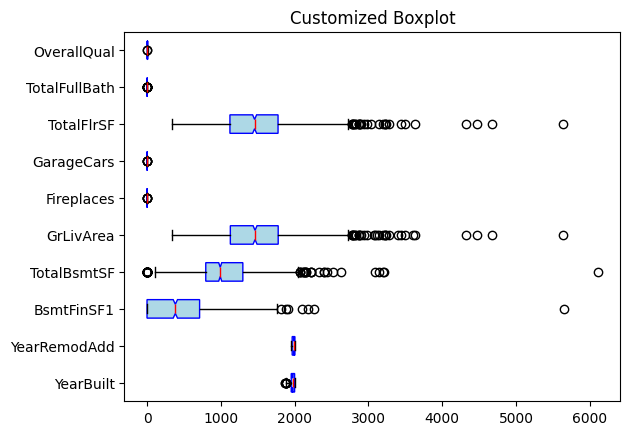

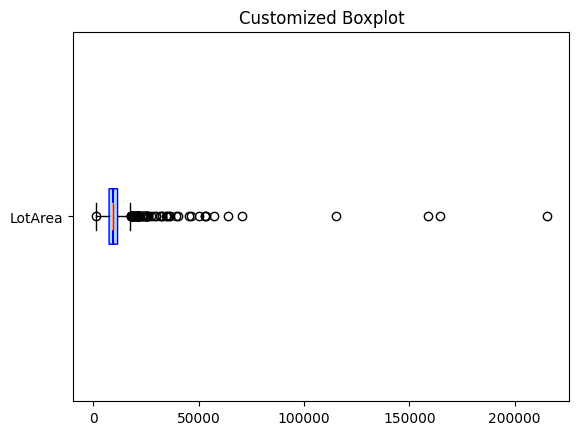

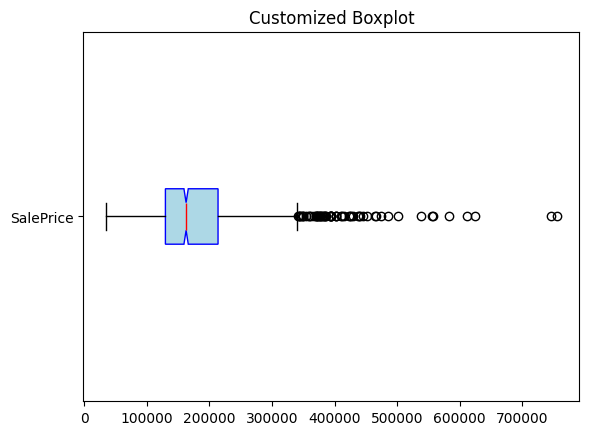

In [6]:
# Investigate the distribution of the numeric features
plt.boxplot(X_train_not_scaled[numeric_features].drop("LotArea", axis=1), 
            tick_labels=numeric_features[1:],
            notch=True,  # Adds notches to the box
            vert=False,  # Horizontal boxplot
            patch_artist=True,  # Fills the box with color
            boxprops=dict(facecolor='lightblue', color='blue'),  # Box style
            medianprops=dict(color='red'))  # Median line style
plt.title("Customized Boxplot")
plt.show()

plt.boxplot(X_train_not_scaled["LotArea"], 
            tick_labels=["LotArea"],
            notch=True,  # Adds notches to the box
            vert=False,  # Horizontal boxplot
            patch_artist=True,  # Fills the box with color
            boxprops=dict(facecolor='lightblue', color='blue'),  # Box style
            medianprops=dict(color='red'))  # Median line style
plt.title("Customized Boxplot")
plt.show()

plt.boxplot(sale_price_train, 
            tick_labels=["SalePrice"],
            notch=True,  # Adds notches to the box
            vert=False,  # Horizontal boxplot
            patch_artist=True,  # Fills the box with color
            boxprops=dict(facecolor='lightblue', color='blue'),  # Box style
            medianprops=dict(color='red'))  # Median line style
plt.title("Customized Boxplot")
plt.show()


### The most of the numeric features has many outliers:
['LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'TotalFlrSF', "YearBuilt"] + "SalePrice"

The distribution is normal only by "LotArea", in other cases it is skewed


### Than it is better to use algorithms which are robust to outliers:
1. Huber Regression (Small to medium-sized outliers in the data)
2. RANSAC Regression (Large outliers in the y direction)
3. Theil Sen Regression (medium-sized outliers in the X data)
4. Quantile Regression (Predicting an interval instead of a point)

### Normalization and standardisation of features for regression


In [18]:
# To keep the outliers use standardisation
scaler = StandardScaler()
scaler_price = StandardScaler()

sale_price_train_std = scaler_price.fit_transform(sale_price_train)
X_train_std = pd.DataFrame(columns=numeric_features)
X_train_std[numeric_features] = scaler.fit_transform(X_train_not_scaled[numeric_features])


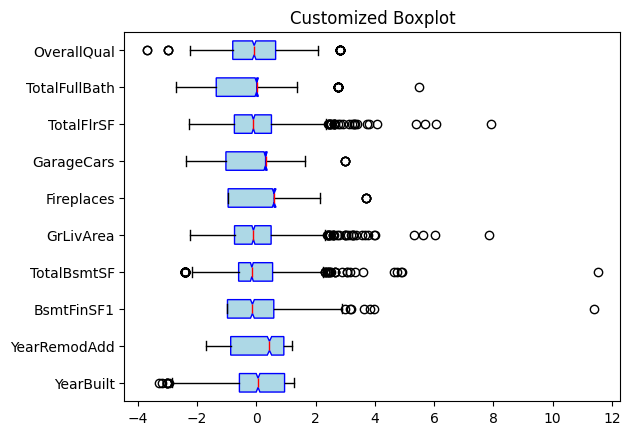

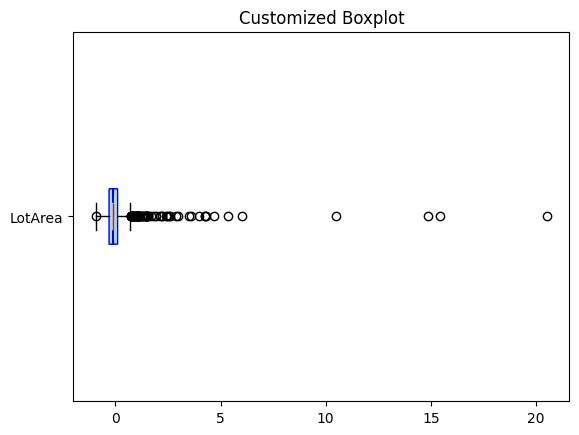

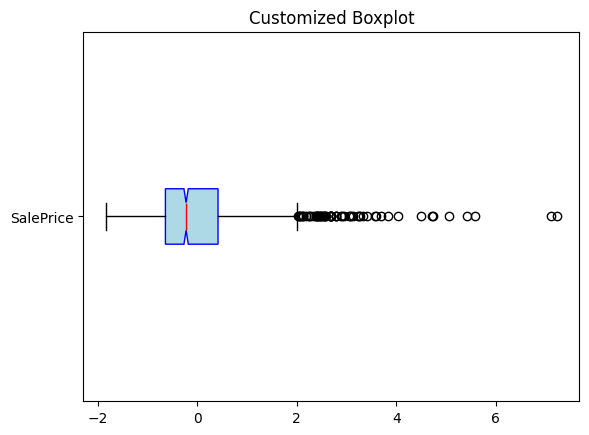

In [8]:
# Distribution of the numeric features after standasdisation
plt.boxplot(X_train_std.drop("LotArea", axis=1), 
            tick_labels=numeric_features[1:],
            notch=True,  # Adds notches to the box
            vert=False,  # Horizontal boxplot
            patch_artist=True,  # Fills the box with color
            boxprops=dict(facecolor='lightblue', color='blue'),  # Box style
            medianprops=dict(color='red'))  # Median line style
plt.title("Customized Boxplot")
plt.show()

plt.boxplot(X_train_std["LotArea"], 
            tick_labels=["LotArea"],
            notch=True,  # Adds notches to the box
            vert=False,  # Horizontal boxplot
            patch_artist=True,  # Fills the box with color
            boxprops=dict(facecolor='lightblue', color='blue'),  # Box style
            medianprops=dict(color='red'))  # Median line style
plt.title("Customized Boxplot")
plt.show()

plt.boxplot(sale_price_train_std, 
            tick_labels=["SalePrice"],
            notch=True,  # Adds notches to the box
            vert=False,  # Horizontal boxplot
            patch_artist=True,  # Fills the box with color
            boxprops=dict(facecolor='lightblue', color='blue'),  # Box style
            medianprops=dict(color='red'))  # Median line style
plt.title("Customized Boxplot")
plt.show()


In [9]:
# Transform categorical features
# One-hot encoding for nominal features:
# LandContour, MSZoning, Neighborhood

# LabelEncoding for ordinal features:
# 1. ExterQual - ordinal: PO < FA < TA < Gd < Ex
# 2. KitchenQual - ordinal: PO < FA < TA < Gd < Ex
# 3. FireplaceQu - ordinal: NA < PO < FA < TA < Gd < Ex
# 4. GarageFinish - ordinal ???  NA < Unf < RFn < Fin	
# 5. BsmtQual - ordinal: PO < FA < TA < Gd < Ex
# 6. OverallQual - ordinal 1 < ... < 10

# Label Encoding
label_encoder = LabelEncoder()

# 1. set classes PO < FA < TA < Gd < Ex
label_encoder.classes_ = np.array(['Po', 'Fa','TA', 'Gd', 'Ex'])
#print(X_train["ExterQual"].unique())
#print(X_train[["ExterQual", "KitchenQual", "FireplaceQu", "BsmtQual", "OverallQual"]])
X_train_std["ExterQual"] = label_encoder.transform(X_train_not_scaled["ExterQual"])
X_train_std["KitchenQual"] = label_encoder.transform(X_train_not_scaled["KitchenQual"])

label_encoder.classes_ = np.array(['NA', 'Po', 'Fa','TA', 'Gd', 'Ex'])
X_train_std["FireplaceQu"] = label_encoder.transform(X_train_not_scaled["FireplaceQu"])
X_train_std["BsmtQual"] = label_encoder.transform(X_train_not_scaled["BsmtQual"])
#print(X_train_std[["ExterQual", "KitchenQual", "FireplaceQu", "BsmtQual"]])

label_encoder.classes_ = np.array(['NA', 'Unf', 'RFn','Fin'])
X_train_std["GarageFinish"] = label_encoder.transform(X_train_not_scaled["GarageFinish"])

#print(X_train_std[["ExterQual", "KitchenQual", "FireplaceQu", "BsmtQual"]])

X_train_std["OverallQual"] = X_train_not_scaled["OverallQual"].astype(int)
#X_train_std["OverallQual1"] = X_train["OverallQual"]
#print(X_train["OverallQual"].isna().sum())
#print(X_train.loc[1126, "OverallQual"])
print(X_train_std[["OverallQual"]])


      OverallQual
0               7
1               6
2               7
3               7
4               8
...           ...
1454            6
1455            6
1456            7
1457            5
1458            5

[1459 rows x 1 columns]


In [10]:
# One Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', drop="first")
nominal_features = ["LandContour", "MSZoning", "Neighborhood"]

#print(one_hot_encoder.fit_transform(X_train_not_scaled[nominal_features]).toarray())
X_train_one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X_train_not_scaled[nominal_features]).toarray(),
                                        columns=one_hot_encoder.get_feature_names_out())

In [11]:
# merge X_train_std andX_train_one_hot_encoded

#print(type(X_train_one_hot_encoded))
#print(X_train_one_hot_encoded)
#print(pd.concat([X_train_std, X_train_one_hot_encoded], axis=1))
X_train_std = pd.concat([X_train_std, X_train_one_hot_encoded], axis=1)

In [12]:
# Split train data
X_train, X_test, y_train, y_test = train_test_split(
    X_train_std, sale_price_train_std, test_size=0.33, random_state=42)

In [13]:
# Define the model
model_linear_regression = LinearRegression()

# Define the hyperparameters to tune
param_grid = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

# Perform grid search
grid = GridSearchCV(estimator=model_linear_regression,
                    param_grid = param_grid, 
                    cv=5,
                    scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

# Report best score and parameters
print(f"Best score: {grid.best_score_:.3f}")
print(f"Best parameters: {grid.best_params_}")



# Evaluate on test set
model_linear_regression = grid.best_estimator_.fit(X_train, y_train)
y_pred = model_linear_regression.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
test_score = model_linear_regression.score(X_test, y_test)
print(f"Test set score: {test_score:.3f}")
#explained_variance = explained_variance_score(y_test, y_pred)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")


Best score: -0.196
Best parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': True}
Test set score: 0.842
Mean Squared Error (MSE): 0.1899
Root Mean Squared Error (RMSE): 0.4358
R-squared (R^2): 0.8422


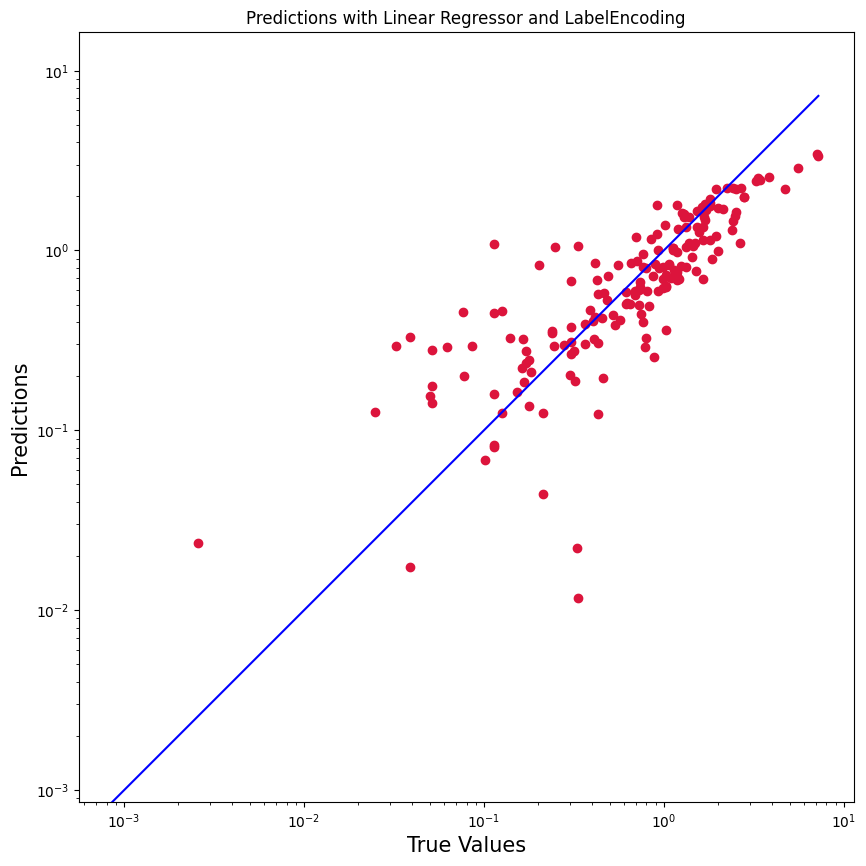

In [15]:
# Plot the difference bewteen the given and the predicted prices
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Predictions with Linear Regressor and LabelEncoding")
plt.axis('equal')
plt.show()

### Das Resultat
Best score: -0.196

Best parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': True}

Test set score: 0.842

Mean Squared Error (MSE): 0.1899

Root Mean Squared Error (RMSE): 0.4358

R-squared (R^2): 0.8422

### Try the linear regression with only OneHot encoding, no label encoding

In [5]:
# To keep the outliers use standardisation
scaler = StandardScaler()

sale_price_train_std = scaler.fit_transform(sale_price_train)
X_train_std_2 = pd.DataFrame(columns=numeric_features)
X_train_std_2[numeric_features] = scaler.fit_transform(X_train_not_scaled[numeric_features])

# One Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', drop="first")

#print(one_hot_encoder.fit_transform(X_train_not_scaled[nominal_features]).toarray())
X_train_one_hot_encoded_2 = pd.DataFrame(one_hot_encoder.fit_transform(X_train_not_scaled[categorical_features]).toarray(),
                                        columns=one_hot_encoder.get_feature_names_out())

X_train_std_2 = pd.concat([X_train_std_2, X_train_one_hot_encoded_2], axis=1)

In [17]:
# Split train data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_train_std_2, sale_price_train_std, test_size=0.33, random_state=42)

In [18]:
# Define the model for one-hot encoded categorical data
model_linear_regression_2 = LinearRegression()

# Define the hyperparameters to tune
param_grid = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

# Perform grid search
grid = GridSearchCV(estimator=model_linear_regression_2,
                    param_grid = param_grid, 
                    cv=5,
                    scoring='neg_mean_squared_error')

grid.fit(X_train_2, y_train_2)

# Report best score and parameters
print(f"Best score: {grid.best_score_:.3f}")
print(f"Best parameters: {grid.best_params_}")



# Evaluate on test set
model_linear_regression_2 = grid.best_estimator_.fit(X_train_2, y_train_2)
y_pred_2 = model_linear_regression_2.predict(X_test_2)

# Calculate regression metrics
mse = mean_squared_error(y_test_2, y_pred_2)
r2 = r2_score(y_test_2, y_pred_2)
test_score = model_linear_regression_2.score(X_test_2, y_test_2)
print(f"Test set score: {test_score:.3f}")
#explained_variance = explained_variance_score(y_test, y_pred)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")


Best score: -0.187
Best parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1, 'positive': False}
Test set score: 0.858
Mean Squared Error (MSE): 0.1703
Root Mean Squared Error (RMSE): 0.4126
R-squared (R^2): 0.8585



### Das resultat R-squared is better as for one-hot encoded ordinal features

Best score: -0.187

Best parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1, 'positive': False}

Test set score: 0.858

Mean Squared Error (MSE): 0.1703

Root Mean Squared Error (RMSE): 0.4126

R-squared (R^2): 0.8585

## Try out Huber Regression
### because of the outliers

In [6]:
X_train_std = X_train_std_2

In [20]:
# Split train data
X_train, X_test, y_train, y_test = train_test_split(
    X_train_std, sale_price_train_std, test_size=0.33, random_state=42)

In [21]:

# Define parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'epsilon': [1.1, 1.35, 1.5, 1.75, 2.0],
    'max_iter': [50, 100, 200]
}

# Perform grid search
grid_search = GridSearchCV(estimator=HuberRegressor(),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')

# Fit HuberRegressor
huber = grid_search.fit(X_train, y_train)


# Report best score and parameters
print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters: {grid_search.best_params_}")


# Evaluate on test set
model_huber_regressor = grid_search.best_estimator_.fit(X_train, y_train)
y_pred = model_huber_regressor.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
test_score = model_huber_regressor.score(X_test, y_test)
print(f"Test set score: {test_score:.3f}")
#explained_variance = explained_variance_score(y_test, y_pred)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")

c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using

Best score: -0.182
Best parameters: {'alpha': 1.0, 'epsilon': 1.1, 'max_iter': 50}
Test set score: 0.880
Mean Squared Error (MSE): 0.1449
Root Mean Squared Error (RMSE): 0.3807
R-squared (R^2): 0.8795


c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number 

### The result by Hubert is better than by linear regression and cat boost classifier

Best score: -0.182

Best parameters: {'alpha': 1.0, 'epsilon': 1.1, 'max_iter': 50}

Test set score: 0.858

Mean Squared Error (MSE): 0.1449

Root Mean Squared Error (RMSE): 0.3807

R-squared (R^2): 0.8795

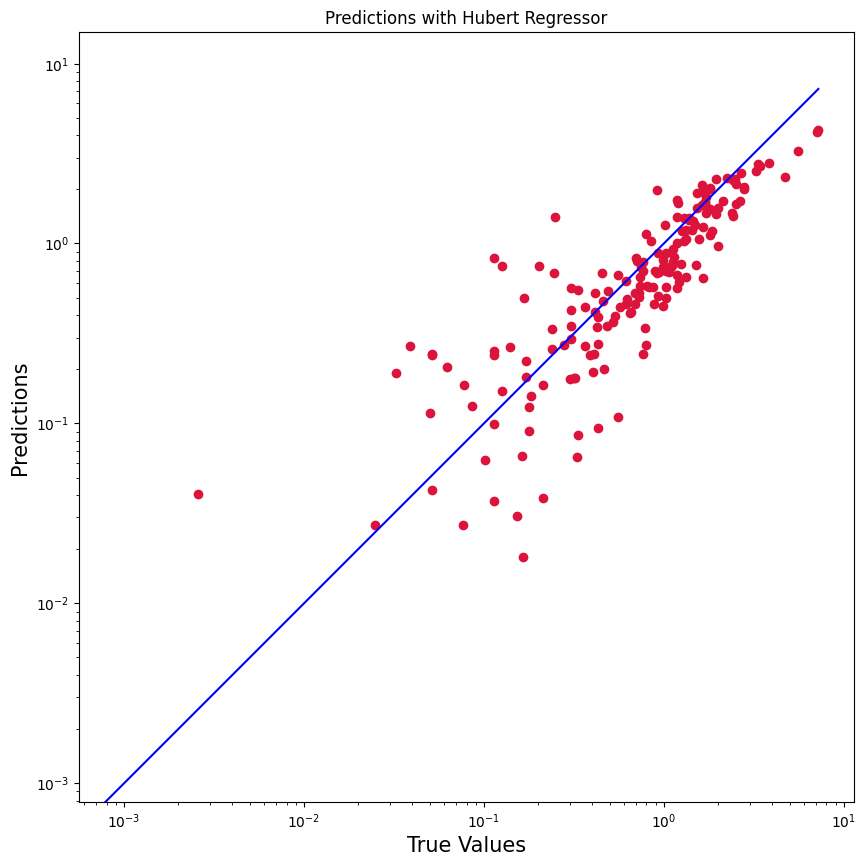

In [22]:
# Plot the difference bewteen the given and the predicted prices
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test.reshape(-1)))
p2 = min(min(y_pred), min(y_test.reshape(-1)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Predictions with Hubert Regressor")
plt.axis('equal')
plt.show()

### RANSAC Regression

In [10]:
# Split train data
X_train, X_test, y_train, y_test = train_test_split(
    X_train_std, sale_price_train_std, test_size=0.33, random_state=42)

In [11]:
# Define parameter grid
param_grid = {
    'min_samples': [0.2, 0.5, 0.8],  # Fraction or absolute number of samples
    'residual_threshold': [1.0, 2.0, 5.0],  # Threshold for inlier classification
    'max_trials': [50, 100, 200]  # Number of iterations
}

# Define a custom scoring function (e.g., negative mean squared error)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search
grid_search = GridSearchCV(estimator=RANSACRegressor(),
                           param_grid=param_grid,
                           cv=3,
                           scoring=scorer,
                           verbose=1)


# Fit RANSAC
grid_search.fit(X_train, y_train)


# Report best score and parameters
print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters: {grid_search.best_params_}")


# Evaluate on test set
ransac_regressor = grid_search.best_estimator_.fit(X_train, y_train)
y_pred = ransac_regressor.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
test_score = ransac_regressor.score(X_test, y_test)
print(f"Test set score: {test_score:.3f}")
#explained_variance = explained_variance_score(y_test, y_pred)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best score: -0.196
Best parameters: {'max_trials': 50, 'min_samples': 0.8, 'residual_threshold': 1.0}
Test set score: 0.887
Mean Squared Error (MSE): 0.1363
Root Mean Squared Error (RMSE): 0.3692
R-squared (R^2): 0.8867


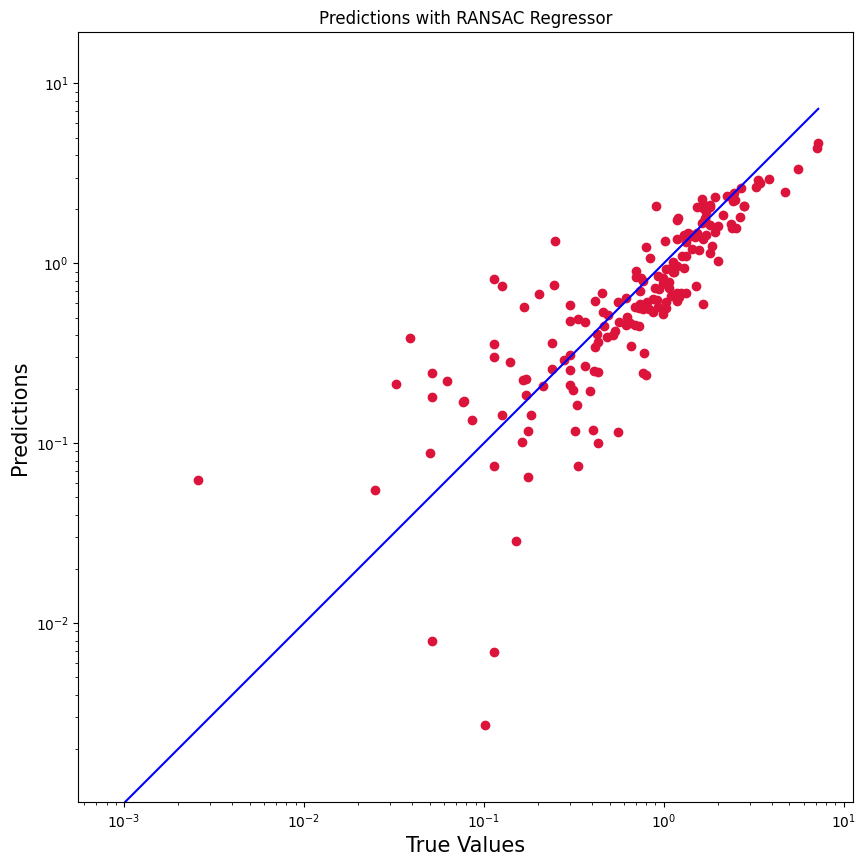

In [25]:
# Plot the difference bewteen the given and the predicted prices
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Predictions with RANSAC Regressor")
plt.axis('equal')
plt.show()

### RANSAC gives the best result between LinearRegression, HubertRegression and CatBoostRegression:

Best score: -0.192

Best parameters: {'max_trials': 50, 'min_samples': 0.2, 'residual_threshold': 1.0}

Test set score: 0.888

Mean Squared Error (MSE): 0.1353

Root Mean Squared Error (RMSE): 0.3678

R-squared (R^2): 0.8876

In [7]:
# Split train data
X_train, X_test, y_train, y_test = train_test_split(
    X_train_std, sale_price_train_std, test_size=0.33, random_state=42)

In [8]:
# Define the parameter grid
param_grid = {
    'max_subpopulation': [1e4, 1e5, 1e6],
    'n_subsamples': [None, 50, 100],
    'max_iter': [300, 500, 1000],
    'tol': [1e-3, 1e-4, 1e-5]
}

param_grid = {
    'max_subpopulation': [1e4, 1e5],
    'n_subsamples': [None, 50],
    'max_iter': [300, 500],
    'tol': [1e-3, 1e-4]
}

# Perform grid search
grid_search = GridSearchCV(TheilSenRegressor(random_state=0),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# Fit TheilSen
grid_search.fit(X_train, y_train)


# Report best score and parameters
print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters: {grid_search.best_params_}")


# Evaluate on test set
theil_sen_regressor = grid_search.best_estimator_.fit(X_train, y_train)
y_pred = theil_sen_regressor.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
test_score = theil_sen_regressor.score(X_test, y_test)
print(f"Test set score: {test_score:.3f}")
#explained_variance = explained_variance_score(y_test, y_pred)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")

c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\

Best score: -0.193
Best parameters: {'max_iter': 300, 'max_subpopulation': 100000.0, 'n_subsamples': None, 'tol': 0.001}


c:\Users\akhma\Desktop\Project\.project\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set score: 0.878
Mean Squared Error (MSE): 0.1465
Root Mean Squared Error (RMSE): 0.3828
R-squared (R^2): 0.8782


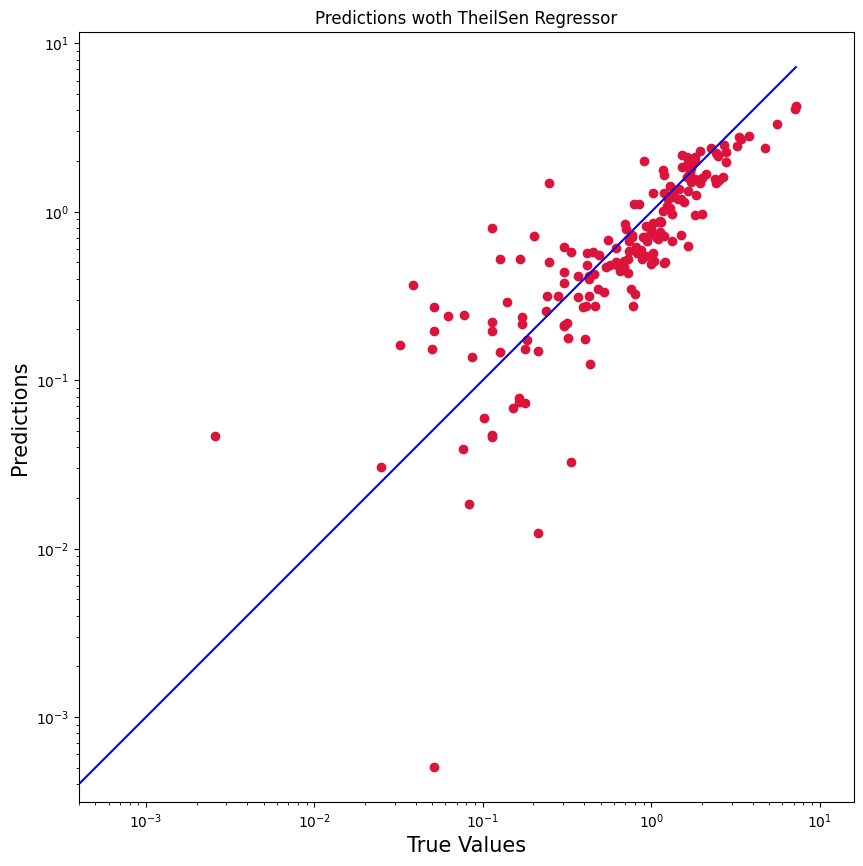

In [9]:
# Plot the difference bewteen the given and the predicted prices
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test.reshape(-1)))
p2 = min(min(y_pred), min(y_test.reshape(-1)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Predictions woth TheilSen Regressor")
plt.axis('equal')
plt.show()

In [13]:
### The result of TheilSenRegressor is a bit worse than of a RANSAC

### Make prediction on the test data with help of RANSAC Regression

In [15]:
# To keep the outliers use standardisation
df_test_std = pd.DataFrame(columns=numeric_features)
df_test_std[numeric_features] = scaler.transform(df_test[numeric_features])

# One Hot Encoding
df_test_one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df_test[categorical_features]).toarray(),
                                        columns=one_hot_encoder.get_feature_names_out())

df_test_std = pd.concat([df_test_std, df_test_one_hot_encoded], axis=1)

y_test_predict = ransac_regressor.predict(df_test_std)

In [16]:
print(y_test_predict)

[[-1.06199515]
 [-0.28630406]
 [ 0.09211092]
 ...
 [-0.23739134]
 [-0.91849849]
 [ 0.43907834]]


In [19]:
# Invert the scaling of the price
original_data = scaler_price.inverse_transform(y_test_predict)
print(original_data)

[[ 96563.66764423]
 [158185.90613363]
 [188247.84533187]
 ...
 [162071.61733959]
 [107963.29005342]
 [215811.53570515]]


In [34]:
predicted_price = pd.DataFrame(data=original_data, index=df_test.index, columns=["Price"])
print(predicted_price)

              Price
0      96563.667644
1     158185.906134
2     188247.845332
3     198336.082069
4     217524.879348
...             ...
1454   74605.371266
1455   87433.161257
1456  162071.617340
1457  107963.290053
1458  215811.535705

[1452 rows x 1 columns]


In [35]:
# Save predicted prices to .csv file 
predicted_price.to_csv('../data/predicted_prices.csv', index=False)